In [1]:
import DSP
using DifferentialEquations
using Plots

In [2]:
# Domain is [-L, L], e is the length of a lipid molecule
L = 30
e = 5
dx = 0.05

# Kernel function
kappa(s) = 0.5*exp.(-abs.(s))
sig_kappa = 1
kappa(s) = 1/(sig_kappa*sqrt(2*pi))*exp.((-0.5/sig_kappa^2)*s.^2)

xker = -10:dx:10
K = kappa(xker)

x = -L:dx:L
nshift = Int(e/dx)
N = size(x)[1]
c0 = 0.1
u_centre = -5
v_centre = 5
sigma = 5
alpha = 1
m = 2
K1 = 1e-2
K2 = 1e-2

0.01

In [3]:
function convwrap(x, w)
    n = size(x)[1]
    f = size(w)[1]
    
    # f should be odd
    # Add on (f - 1)/2 entries of x to each end
    xnew = vcat(x[(n - (f-1)÷2 + 1):end], x, x[1:(f-1)÷2])

    # Perform the convolution and truncate the tails
    y = DSP.conv(xnew, w)[f:end-f+1]
end

convwrap (generic function with 1 method)

In [4]:
mu_fun(u, v) = 1 .- u - circshift(u, -nshift) - v - circshift(v, nshift) 
function bap!(dy, y, p, t)
    u = @view y[1:N]
    v = @view y[N+1:end]
    kuv = convwrap(u + v, K)
    mu = mu_fun(u, v)
    um = u .> 0
    vm = v .> 0

    dy[1:N] = -log.(u) + 2*alpha*kuv + K1./u.^2 + K2./mu.^2 + K2./(circshift(mu, nshift).^2)
    dy[N+1:end] = -log.(v) + 2*alpha*kuv + K1./v.^2 + K2./mu.^2 + K2./(circshift(mu, -nshift).^2)
    
    dy .-= sum(dy)/(2*N) # conservation of mass constraint
end

# Initial conditions 
u0 = c0 .+ m/(sigma*sqrt(2*pi))*exp.(-0.5*(x .- u_centre).^2/sigma^2) 
v0 = c0 .+ m/(sigma*sqrt(2*pi))*exp.(-0.5*(x .- v_centre).^2/sigma^2) 
y0 = [u0; v0]
tspan = (0, 0.01)
prob = ODEProblem(bap!, y0, tspan);
sol = solve(prob);


┌ Info: Saved animation to 
│   fn = /Users/rgbrown/github/lipids/notebooks/tmp.gif
└ @ Plots /Users/rgbrown/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/Users/rgbrown/github/lipids/notebooks/tmp.gif")
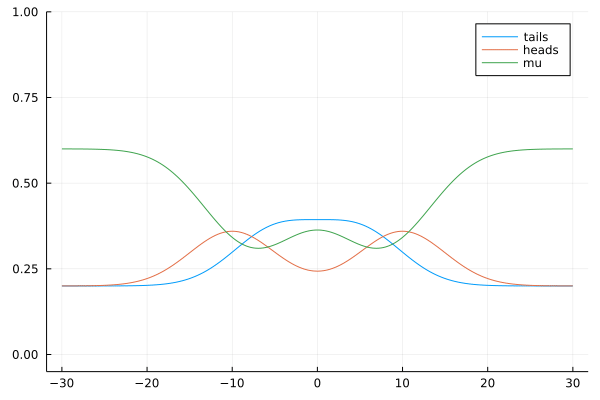

In [5]:
function plotuv(y; ylim=(0, 0.5))
    u = @view y[1:N]
    v = @view y[N+1:end]
    mu = mu_fun(u, v)
    plot(x, u + v, ylim=ylim, label="tails")
    plot!(x, circshift(u, -nshift) + circshift(v, nshift), label="heads")
    plot!(x, mu, label="mu")  
end

@gif for t in range(0, tspan[2], length=40)
    plotuv(sol(t), ylim=(-0.05, 1))
end

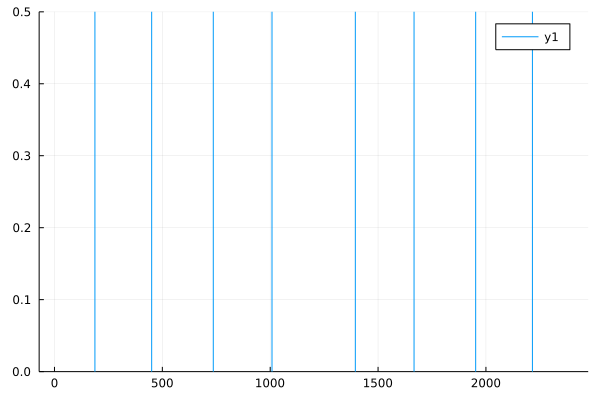

In [6]:
plot(sol(0.6)[1:end], ylim=(0, 0.5))

In [7]:
size(xker)


(401,)

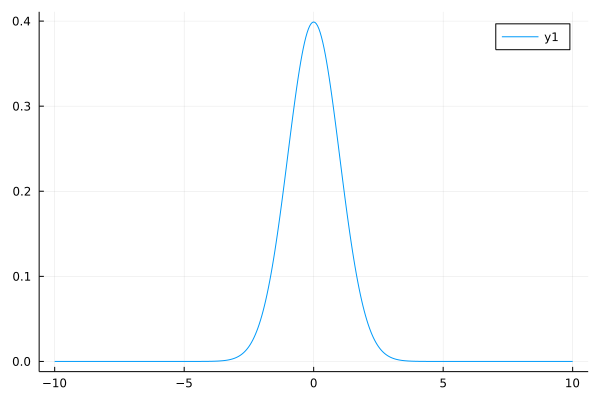

In [8]:
plot(xker, K)